## Here we will take the input data from FER2013 and retrain the FULL MobileNet with this data



*   Make changes to MobileNetTransfer to Augment the Data using ImageDataGenerator class. 
*   Train the **entire** MobileNet




*   Apply GAP to get 1280 Neurons on the output layer
*   Use 256 nodes in the classifier layer before the 7 outputs




Follow the example from Oarriaga ...

1.   use the ImageDataGenerator Class. Incorporate the exact same arguements as Oarriaga for the training data.
2.   use the aug_image function as the preprocessing_function to convert to 3 channel -- note that this runs after the augmentation operations!!!
3.   pass the entire validation set rather than a generator for this -- don't really want to mess around with this.


This does the training on the augmented Public data, validation on the validation set, and then the testing based on the PrivateTest data.




In [ ]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
# Use 'ls' to see if the drive is available; if not, then run this
# Might need to do this once per session
from google.colab import drive
drive.mount('/content/drive/')
# Has to be done once per notebook and then get an authentication code

Mounted at /content/drive/


In [ ]:
# Change directory to load the data -- change back after it has been loaded!!!
import os
os.chdir("/content/drive/My Drive/2021_SusySu_Thesis")
!pwd
!ls

# Use a number of custom code files to make it easier to manipulate the data.
# This is the easiest way to make the modules accessible:
import sys
sys.path.append('./utils_revision')

/content/drive/My Drive/2021_SusySu_Thesis
 Coding				 'Susy RealTime_MNetCode6_100EpochsReLU.ipynb'
'ECE497_susy_Design Paper.gdoc'   Untitled1.ipynb
 fer2013.csv			  utils
 progress_SusySu_498.gdoc	  utils_revision


In [ ]:
# DEBUG
os.chdir("./utils_revision")
!ls

aug_datasets.py       grad_cam.py   my_model.h5		       preproc.py
data_augmentation.py  inference.py  output-onlinejpgtools.jpg  __pycache__
datasets.py	      MNV2	    preprocessor.py	       vizualizer.py


In [ ]:
import numpy as np
import PIL
from imageio import imread


# This function makes the data uniformly distributed on [-1,1]
# -- we assume uniform on [0,255] coming in, then division by 255
# followed by subtraction and multiplication => [-1,1]
def preproc_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert the Grayscale Images to RGB by stacking
def aug_image(x):
    
    # convert to 3 channel (RGB)
    x = np.stack((x,)*3, axis=-1) 
    
    return x
  

# Convert the entire Validation Set at once
def aug_val_data(x):
    num_samples = x.shape[0]
    x_data = [aug_image(im) for im in x[0:num_samples]]
    return np.array(x_data)
  

# Load the data here first

from aug_datasets import DataManager
from aug_datasets import split_valtest_data

# Split into Training, Validation, and Test sets so we can determine the 
# performance based on the test set. 

# Parameters for NN
batch_size = 32

# Reshape the face data for MobileNet -- has to be in 96x96x3
input_shape = (96, 96, 3)
verbose = 1
num_classes = 7
patience = 30

dataset_name = 'fer2013'
print('Training dataset:', dataset_name)

# The DataManager class supports many different datasets. For now, it will
# just be used to import FER2013 but can be expanded to do more later.
data_loader = DataManager(dataset_name, dataset_path='/content/drive/My Drive/2021_SusySu_Thesis/fer2013.csv', image_size=input_shape[:2])


# Load the data which is just FER2013 and resize to 96x96 -- this returns
# a Numpy array which is float32 and the right dimensions
faces, emotions = data_loader.get_data()

#what data type is returned from get_data()?

# Normalizes the data to [-1,1]
faces = preproc_input(faces)

# Figure out the number of samples and number of classes
num_samples, num_classes = emotions.shape

# Split the data into three parts
train_data, val_data, test_data = split_valtest_data(faces, emotions)

train_faces, train_emotions = train_data
val_faces, val_emotions = val_data
test_faces, test_emotions = test_data

# Change the data from GrayScale to RGB by just replicating across the
# 3 dimensions

# Debug -- make sure that we have the right data sizes
print(train_faces.shape)
print(val_faces.shape)
print(test_faces.shape)
print(train_faces.dtype)


Training dataset: fer2013
(28709, 96, 96)
(3589, 96, 96)
(3589, 96, 96)
float32


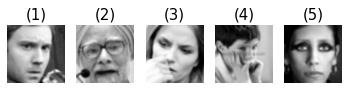

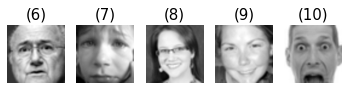

In [ ]:
# DEBUG

# Debug -- show the images are alright -- can skip over for now ...

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def show_images(images):
    """
    images : numpy arrays
    """
    n_images = len(images)
    titles = ['(%d)' % i for i in range(1, n_images + 1)]
    num = 5
    iter_num = np.ceil(n_images / num).astype(int)
    for i in range(iter_num):
        fig = plt.figure()
        sub_images = images[i * num:num * (i + 1)]
        sub_titles = titles[i * num:num * (i + 1)]
        for n, (image, title) in enumerate(zip(sub_images, sub_titles)):
            a = fig.add_subplot(1, np.ceil(len(sub_images)), n + 1)
            if image.ndim == 2:
                plt.gray()
            a.set_title(title, fontsize=15)
            plt.axis('off')
            plt.imshow(image)
        
show_images(train_faces[:10])

In [ ]:
# DEBUG

# Check that the image data is in the form of a Keras Tensor
from keras import backend
from keras.layers import Input

# Check the image data format: channels_last
frmt = backend.image_data_format()
print(frmt)

# Take out this code segment and run once to see if we need to make a check here or not !!!
target_size = 96
input_tensor = Input(shape=(target_size, target_size, 3))

if not backend.is_keras_tensor(input_tensor):
  print("Path 1")
  img_input = Input(tensor=input_tensor, shape=input_shape)
else:
  print("Path 2")
  img_input = input_tensor
   

channels_last
Path 2


In [ ]:
from keras import backend

channel_axis = 1 if backend.image_data_format() == 'channels_first' else -1
alpha = 1

def correct_pad(backend, inputs, kernel_size):
    """Returns a tuple for zero-padding for 2D convolution with downsampling.

    # Arguments
        input_size: An integer or tuple/list of 2 integers.
        kernel_size: An integer or tuple/list of 2 integers.

    # Returns
        A tuple.
    """
    img_dim = 2 if backend.image_data_format() == 'channels_first' else 1
    input_size = backend.int_shape(inputs)[img_dim:(img_dim + 2)]

    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)

    if input_size[0] is None:
        adjust = (1, 1)
    else:
        adjust = (1 - input_size[0] % 2, 1 - input_size[1] % 2)

    correct = (kernel_size[0] // 2, kernel_size[1] // 2)

    return ((correct[0] - adjust[0], correct[0]),
            (correct[1] - adjust[1], correct[1]))


In [ ]:
from keras.layers import Input, Add
from keras.layers import Convolution2D, Dropout, Conv2D, SeparableConv2D, DepthwiseConv2D
from keras.layers import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import BatchNormalization, Activation, ReLU
from keras.layers import Flatten, Dropout, Dense
from keras.layers.convolutional import ZeroPadding2D

from keras.models import Model
from keras.models import Sequential

from tensorflow.keras.optimizers import Adam 

def custom_inverted_res(inputs, expansion, stride, alpha, filters, block_id):

    in_channels = backend.int_shape(inputs)[channel_axis]
    
    # Note: the number of filters has to be divisible by 8 for some reason
    # Just make sure this is the case ...
    # and so can comment out the code here
    # pointwise_conv_filters = int(filters * alpha)
    # pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    pointwise_filters = int(filters * alpha)
    print(pointwise_filters)
    
    x = inputs
    prefix = 'block_{}_'.format(block_id)

    if block_id:
        # Expand
        x = Conv2D(expansion * in_channels,
                          kernel_size=1,
                          padding='same',
                          use_bias=False,
                          activation=None,
                          name=prefix + 'expand')(x)
        x = BatchNormalization(axis=channel_axis,
                                      epsilon=1e-3,
                                      momentum=0.999,
                                      name=prefix + 'expand_BN')(x)
        x = ReLU(name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'

    # Depthwise
    if stride == 2:
        x = ZeroPadding2D(padding=correct_pad(backend, x, 3),
                                 name=prefix + 'pad')(x)
    
    x = DepthwiseConv2D(kernel_size=3,
                               strides=stride,
                               activation=None,
                               use_bias=False,
                               padding='same' if stride == 1 else 'valid',
                               name=prefix + 'depthwise')(x)
    x = BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name=prefix + 'depthwise_BN')(x)

    x = ReLU(name=prefix + 'depthwise_relu')(x)

    # Project
    x = Conv2D(pointwise_filters,
                      kernel_size=1,
                      padding='same',
                      use_bias=False,
                      activation=None,
                      name=prefix + 'project')(x)
    x = BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name=prefix + 'project_BN')(x)

    if in_channels == pointwise_filters and stride == 1:
        return Add(name=prefix + 'add')([inputs, x])
    return x

In [ ]:
# Define Model Characteristics
target_size = 96
alpha = 1

def build_model( ):
  
    img_input = Input(shape=(target_size, target_size, 3))
    
    # 1. Convolution
    first_block_filters = 64
    x = ZeroPadding2D(padding=correct_pad(backend, img_input, 3),
                             name='Conv1_pad')(img_input)
    
    x = Conv2D(first_block_filters,
                      kernel_size=3,
                      strides=(2, 2),
                      padding='valid',
                      use_bias=False,
                      name='Conv1')(x)
    x = BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='bn_Conv1')(x)
    x = ReLU( name='Conv1_relu')(x)
    
    
    # 0. DW Convolution
    # With block_id=0, this is expanded_conv and so this is a Depthwise convolution
    # with 3x3 filters, followed by 1x1 filters
    x = custom_inverted_res(x, filters=first_block_filters/2, alpha=alpha, stride=1,
                            expansion=1, block_id=0)
    
    # 1. BLOCK -- Expand by 4, Stride 2, Compress (No Add since Stride 2)
    x = custom_inverted_res(x, filters=32, alpha=alpha, stride=2,
                            expansion=4, block_id=1)
      
    # 2. RESBLOCK -- Expand by 4, Stride 1, Compress to Same Size => Add
    x = custom_inverted_res(x, filters=32, alpha=alpha, stride=1,
                            expansion=4, block_id=2)   
    
    # 3. BLOCK -- Expand by 4, Stride 2, Compress (No Add since Stride 2)
    x = custom_inverted_res(x, filters=32, alpha=alpha, stride=2,
                            expansion=4, block_id=3)
    
    # 4. RESBLOCK -- Expand by 4, Stride 1, Compress to Same Size => Add
    x = custom_inverted_res(x, filters=32, alpha=alpha, stride=1,
                            expansion=2, block_id=4)
 
    # 5. BLOCK -- Expand by 4, Stride 2, Compress (No Add since Stride 2)
    x = custom_inverted_res(x, filters=32, alpha=alpha, stride=2,
                            expansion=4, block_id=5)
      
    # 6. RESBLOCK -- Expand by 4, Stride 1, Compress to Same Size => Add
    x = custom_inverted_res(x, filters=32, alpha=alpha, stride=1,
                            expansion=4, block_id=6)   
    
    # 7. BLOCK -- Expand by 4, Stride 1, Compress (No Add since Stride 2)    
    x = custom_inverted_res(x, filters=64, alpha=alpha, stride=2,
                            expansion=2, block_id=7)
    
    # 8. RESBLOCK -- Expand by 4, Stride 1, Compress to Same Size => Add    
    # x = custom_inverted_res(x, filters=64, alpha=alpha, stride=1,
    #                         expansion=2, block_id=8)
    
    # Following Arriaga Example
    # x = Conv2D(num_classes, (3, 3), padding='same')(x)
    
    # This follows the code in MBNet
    # 10. Last Layer -- Use 1x1 to expand to 512 channels
    last_block_filters = 64

    x = Conv2D(last_block_filters,
                      kernel_size=1,
                      use_bias=False,
                      name='Conv_1')(x)
    x = BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='Conv_1_bn')(x)
    x = ReLU( name='out_relu')(x)

    
 #   if include_top:
 #       x = layers.GlobalAveragePooling2D()(x)
 #       x = layers.Dense(classes, activation='softmax',
 #                        use_bias=True, name='Logits')(x)
 #   else:
 #       if pooling == 'avg':
 #           x = layers.GlobalAveragePooling2D()(x)
 #       elif pooling == 'max':
 #           x = layers.GlobalMaxPooling2D()(x)
  
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax',
                         use_bias=True, name='Predictions')(x)


    # Create model
    model = Model(img_input, x)
    return model

model = build_model()
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()

32
32
32
32
32
32
32
64
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 64)   1728        Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 64)   256         Conv1[0][0]                      
______________________________________________________________________

In [ ]:
# Use an ImageDataGenerator for the Training Data
# Load the entire validation set for validation testing

val_faces_aug = aug_val_data(val_faces)
print(val_faces_aug.shape)
print(val_faces_aug.dtype)

train_faces_aug = aug_val_data(train_faces)
print(train_faces_aug.shape)
print(train_faces_aug.dtype)

test_faces_aug = aug_val_data(test_faces)
print(test_faces_aug.shape)
print(test_faces_aug.dtype)

# Use an ImageDataGenerator for the Training Data
# Load the entire validation set for validation testing
from keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

(3589, 96, 96, 3)
float32
(28709, 96, 96, 3)
float32
(3589, 96, 96, 3)
float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


x (32, 96, 96, 3) float32 -1.0 1.0
y (32, 7) uint8 0 1


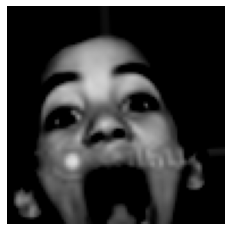

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


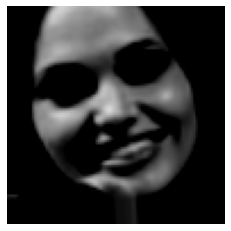

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


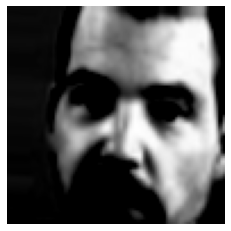

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


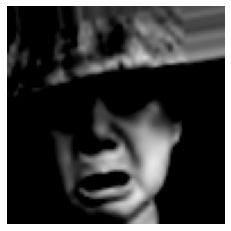

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


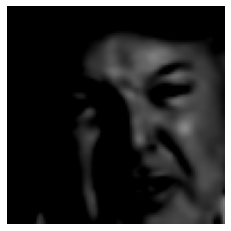

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


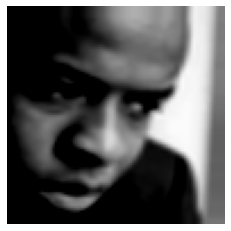

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


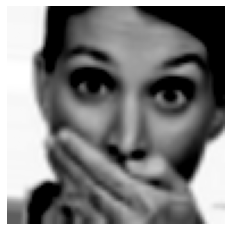

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


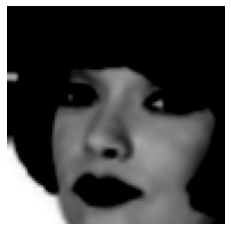

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


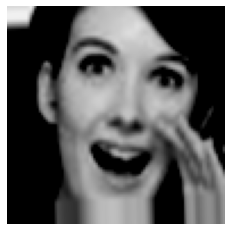

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


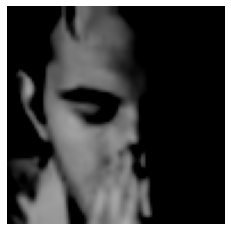

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


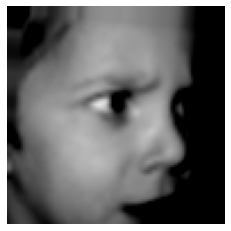

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


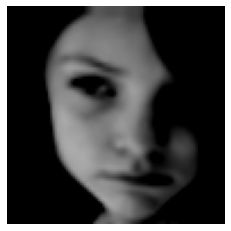

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


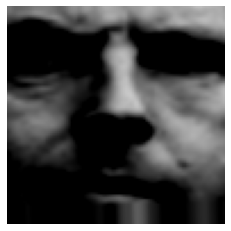

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


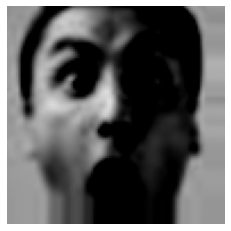

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


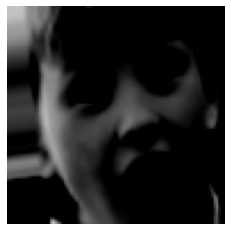

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


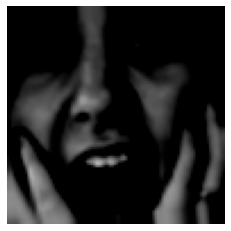

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


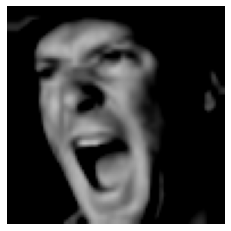

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


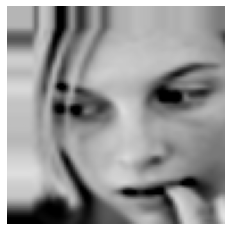

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


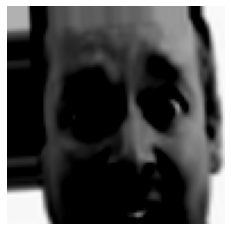

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


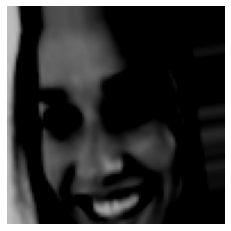

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


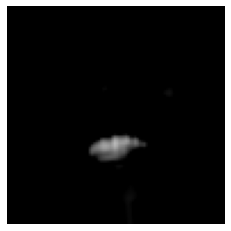

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


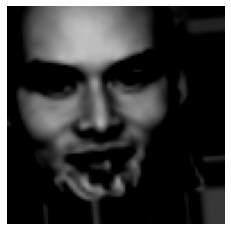

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


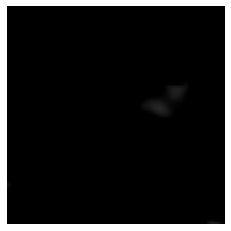

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


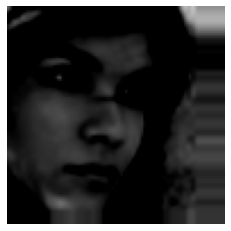

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


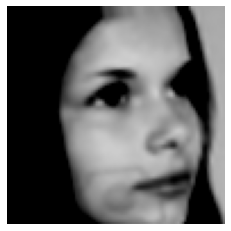

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


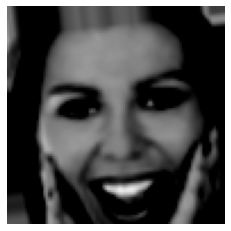

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


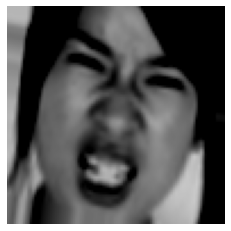

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


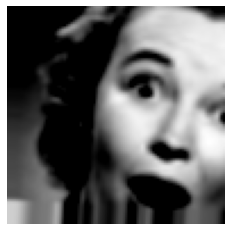

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


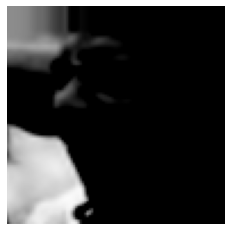

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


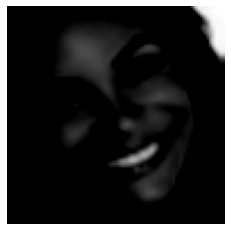

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


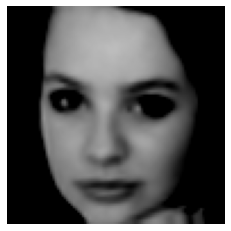

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


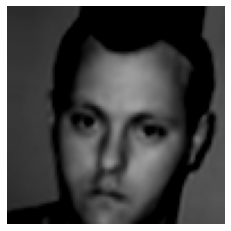

In [ ]:
# Debug -- Test the data generator:
test_gen = data_generator.flow(train_faces_aug, train_emotions, batch_size) 
                               #save_to_dir='./TestGen/', 
                               #save_prefix='test')

t_x,t_y = test_gen.next()
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())

for i in range(0,len(t_y)):
    im = t_x[i]
    plt.imshow(im)
    plt.axis('off')
    plt.show()

In [ ]:
# Define some functions for printing the results ....

labels = ['angry', 'disgust','fear', 'happy', 'sad', 'surprise', 'neutral']

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import random

from sklearn.metrics import confusion_matrix

def plot_distribution(y_true, y_pred):
    ind = np.arange(1.5,8,1)  # the x locations for the groups
    width = 0.35   
    fig, ax = plt.subplots()
    true = ax.bar(ind, np.bincount(y_true), width, color='b', alpha=1.0)
    pred = ax.bar(ind + width, np.bincount(y_pred), width, color='r', alpha=0.3)
    ax.set_xticks(np.arange(1.5,7,1))
    ax.set_xticklabels(labels, rotation=30, fontsize=14)
    ax.set_xlim([1.25, 8.5])
    ax.set_ylim([0, 1000])
    ax.set_title('Test Images: True and Predicted Labels')
    plt.tight_layout()
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,7):
        for j in range(0,7):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    # ax.set_title('Confusion Matrix')
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def plot_confusion_matrix_norm(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)

    
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return ax


./MNV2/RT5_200
./MNV2/RT5_200TrnHist


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
897/897 [==============================] - 133s 112ms/step - loss: 1.7482 - categorical_accuracy: 0.2837 - val_loss: 1.8472 - val_categorical_accuracy: 0.2494

Epoch 00001: val_loss improved from inf to 1.84720, saving model to ./MNV2/RT5_200.01-0.25.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
897/897 [==============================] - 100s 111ms/step - loss: 1.5606 - categorical_accuracy: 0.3878 - val_loss: 1.8845 - val_categorical_accuracy: 0.1819

Epoch 00002: val_loss did not improve from 1.84720
Epoch 3/100
897/897 [==============================] - 101s 112ms/step - loss: 1.4218 - categorical_accuracy: 0.4550 - val_loss: 1.9842 - val_categorical_accuracy: 0.1819

Epoch 00003: val_loss did not improve from 1.84720
Epoch 4/100
897/897 [==============================] - 100s 112ms/step - loss: 1.3252 - categorical_accuracy: 0.4934 - val_loss: 1.8145 - val_categorical_accuracy: 0.1953

Epoch 00004: val_loss improved from 1.84720 to 1.81451, saving model to ./MNV2/RT5_200.04-0.20.hdf5
Epoch 5/100
897/897 [==============================] - 101s 112ms/step - loss: 1.2651 - categorical_accuracy: 0.5181 - val_loss: 1.3643 - val_categorical_accuracy: 0.4714

Epoch 00005: val_loss improved from 1.81451 to 1.36432, saving model to ./MNV2/RT5_200.05-0.47.hdf5
Epoch 6/10

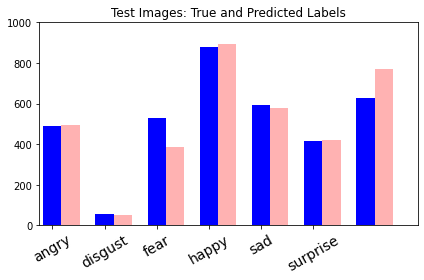

              precision    recall  f1-score   support

       angry       0.62      0.62      0.62       491
     disgust       0.54      0.49      0.51        55
        fear       0.52      0.38      0.44       528
       happy       0.87      0.89      0.88       879
         sad       0.55      0.54      0.54       594
    surprise       0.78      0.78      0.78       416
     neutral       0.63      0.77      0.69       626

    accuracy                           0.68      3589
   macro avg       0.64      0.64      0.64      3589
weighted avg       0.67      0.68      0.67      3589

Normalized confusion matrix
[[0.62 0.01 0.1  0.03 0.12 0.01 0.1 ]
 [0.29 0.49 0.05 0.04 0.09 0.02 0.02]
 [0.15 0.01 0.38 0.03 0.2  0.1  0.12]
 [0.02 0.   0.02 0.89 0.02 0.02 0.04]
 [0.08 0.01 0.1  0.04 0.54 0.01 0.22]
 [0.02 0.   0.08 0.07 0.01 0.78 0.02]
 [0.03 0.   0.04 0.04 0.1  0.01 0.77]]


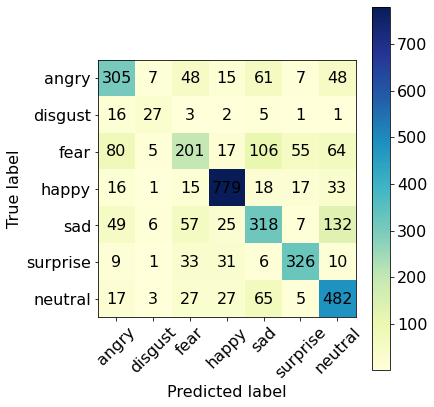

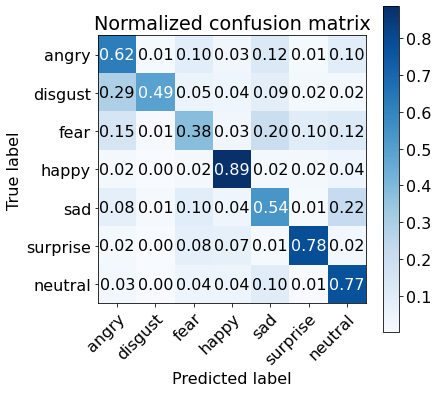

0.6792978545555866



 Accuracy: 


In [ ]:
# Run the model ... will/content/drive/My Drive/2021_SusySu_Thesis take about 2.5 hours. Ideally, leave the window open 
# so that all the results are in the window

from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
import keras
import time

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

# Model Fit Parameters
batch_size = 32
num_epochs = 100
verbose = 1
num_classes = 7
patience = 20 # Note that patience is divided by 4 below ...
              #patience = 40 in older version
base_path = './MNV2/RT5_200'
hist_file = './MNV2/RT5_200TrnHist'
print(base_path)
print(hist_file)

# Setup the callbacks
log_file_path = base_path + '_training.csv'
final_model_path = base_path + '_Final.hdf'

# Note: append=False overwrites the previous file
csv_logger = CSVLogger(log_file_path, append=False)
# Note: leave out this for now:
early_stop = EarlyStopping('val_loss', patience=patience)
# and removed from callbacks below ...

reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                              patience=int(patience/2), verbose=1) #it was patience/4
trained_models_path = base_path 
model_names = trained_models_path + '.{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5'

model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                save_best_only=True)
time_callback = TimeHistory()

callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]
#callbacks = [model_checkpoint, csv_logger, reduce_lr, time_callback]
history = model.fit_generator(
    data_generator.flow(train_faces_aug, train_emotions, batch_size),
    steps_per_epoch=len(train_emotions) / batch_size,
    verbose=1,
    epochs=num_epochs, callbacks=callbacks,
    validation_data=(val_faces_aug, val_emotions))

#print(time_callback.times)

# Save the final model and the history file
#model.save("saved_model")
model.save('my_model.h5')

import pickle
with open(hist_file, 'wb') as file_pi:
  pickle.dump(history.history, file_pi)
  
# Make Predictions & Save to Output File
y_prob = model.predict(test_faces_aug, batch_size=32, verbose=0)
y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in test_emotions]

predict_file_path = base_path + '_prediction.csv'
output = open(predict_file_path, 'w')
for p in y_pred:
    output.write(str(p))
    output.write("\n")

output.close()

# Plot the results using a distribution and a confusion matrix
plot_distribution(y_true, y_pred)

# Give the table of results
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labels))

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.YlGnBu)



# Plot normalized confusion matrix

np.set_printoptions(precision=2)
plot_confusion_matrix_norm(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


# Get accuracy:
print("\n\n Accuracy: ")
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

In [ ]:
# Get accuracy:
print("\n\n Accuracy: ")
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)



 Accuracy: 


0.6792978545555866

Text(0, 0.5, 'loss')

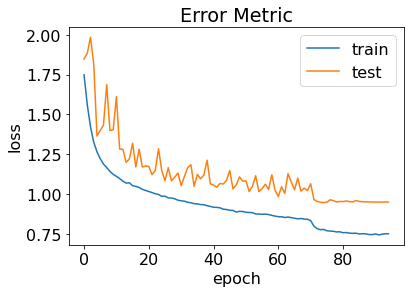

In [ ]:
from matplotlib import pyplot
pyplot.title('Error Metric')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.xlabel('epoch')
pyplot.ylabel('loss')

(1440, 1080, 3)
The image consists of 1555200 pixels


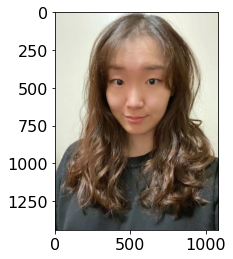

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

painting=plt.imread("/content/drive/MyDrive/2021_SusySu_Thesis/Coding/Real_Time_Image/susy_test_image.jpeg")
print(painting.shape)
print("The image consists of %i pixels" % (painting.shape[0] * painting.shape[1]))
plt.imshow(painting);

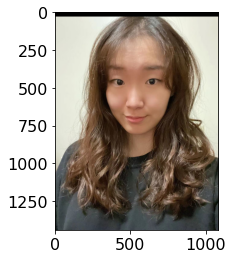

In [ ]:
painting2 = painting.copy()    # don't mess the original painting!
painting2[0:30, :, :] = 1.0    # max value for all three components produces white
plt.imshow(painting2);

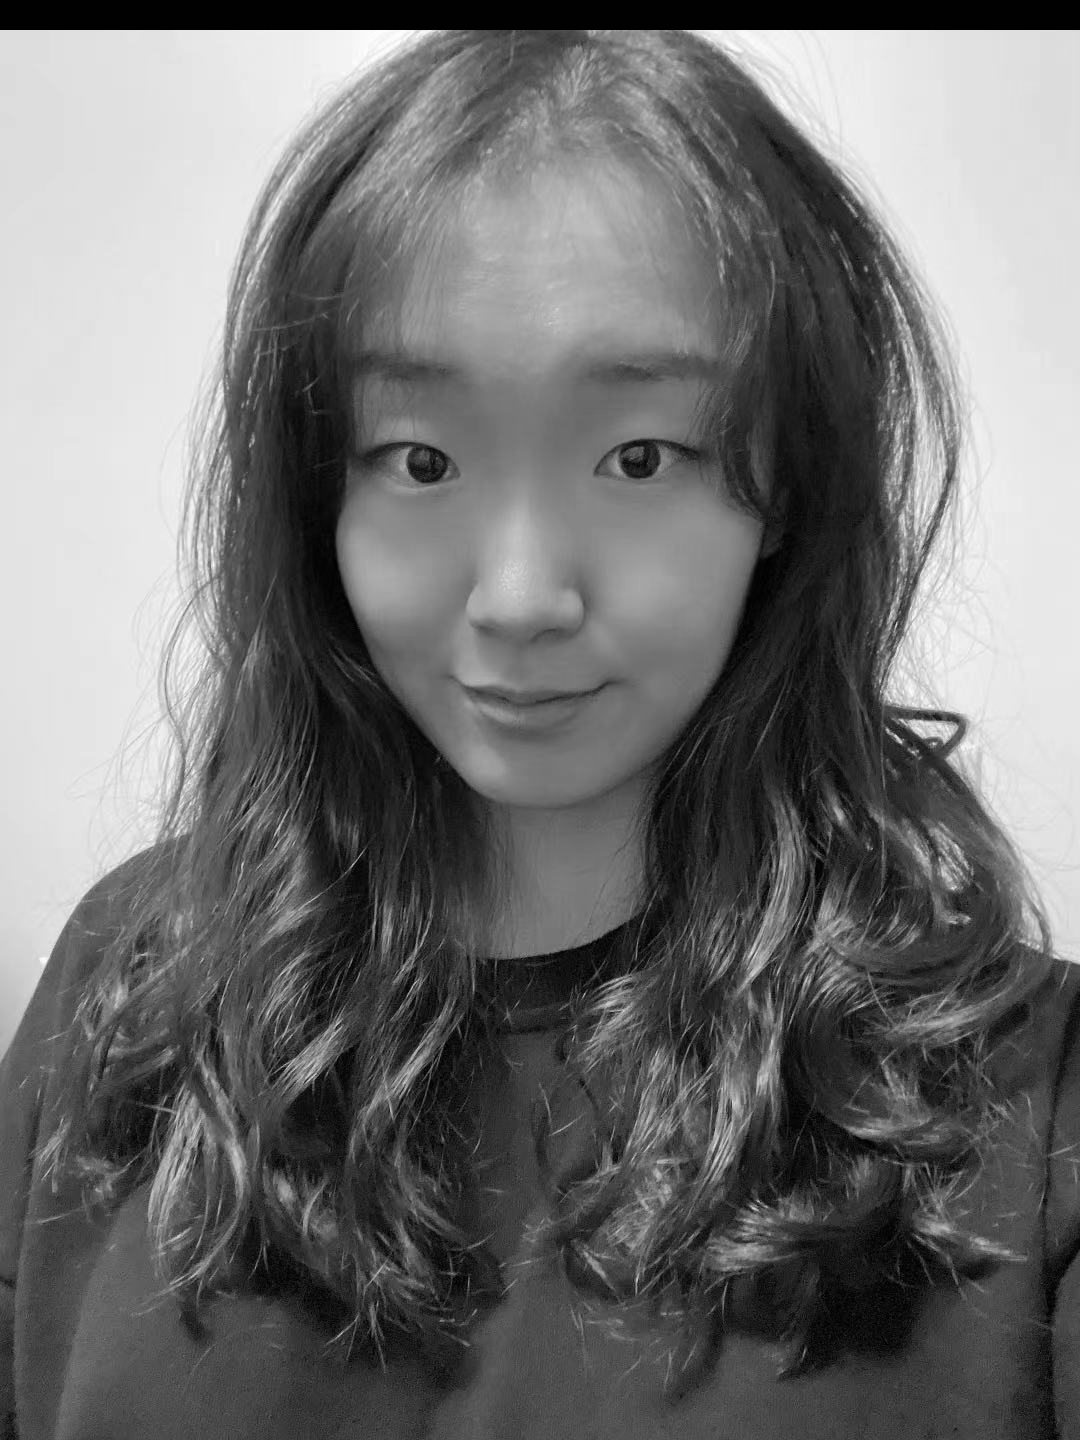

(1440, 1080)


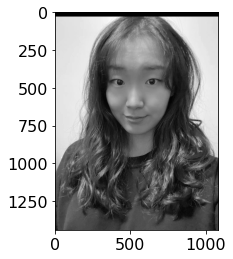

In [ ]:
import cv2 as cv
from google.colab.patches import cv2_imshow
gray_image = cv.cvtColor(painting2, cv.COLOR_BGR2GRAY)
cv2_imshow(gray_image)
plt.imshow(gray_image)
print(gray_image.shape)

In [ ]:
from numpy import asarray
numpydata = asarray(im)


(1440, 1080)


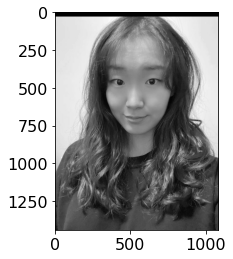

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

gray = rgb2gray(painting2)

plt.imshow(gray, cmap = plt.get_cmap('gray'))
print(gray.shape)

Resized Dimensions: (96, 96, 3)


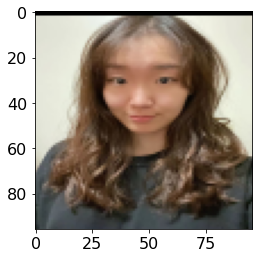

In [ ]:
# resize the image to 96*96*3
width = 96
height = 96
dim = (width, height)
resized_image = cv.resize(painting2,dim,interpolation = cv.INTER_AREA)


print('Resized Dimensions:', resized_image.shape)

plt.imshow(resized_image)

(96, 96)


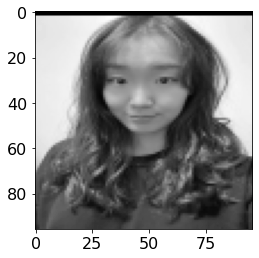

In [ ]:
gray2 = rgb2gray(resized_image)
plt.imshow(gray2, cmap = plt.get_cmap('gray'))
print(gray2.shape)

(96, 96, 3)


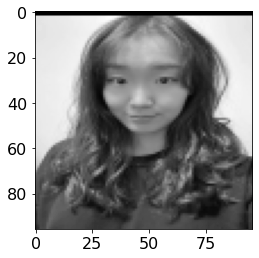

In [ ]:
img = gray2

stacked_img = np.stack((img,)*3, axis=-1)
print(stacked_img.shape)

plt.imshow(gray2, cmap = plt.get_cmap('gray'))

In [ ]:
#normalize image
nor_image = preproc_input(stacked_img)
nor_image = np.expand_dims(nor_image, axis=0)

In [ ]:
image_array = np. array(stacked_img)
print(image_array.shape)

(96, 96, 3)


In [ ]:
import tensorflow as tf
from tensorflow import keras
new_model = tf.keras.models.load_model("my_model.h5")


In [ ]:
y_prob = new_model.predict(nor_image, batch_size=32, verbose=0)
y_pred1 = [np.argmax(prob) for prob in y_prob]
print("The predicted image emotion is: ", labels[y_pred1[0]])

The predicted image emotion is:  neutral
